In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Total training images 1595
Total training images (Damaged) 1365
Total training images (Damaged) 230

Total validation images 459
Total training images (Damaged) 229
Total training images (Damaged) 230

Total Number of Images:  2054


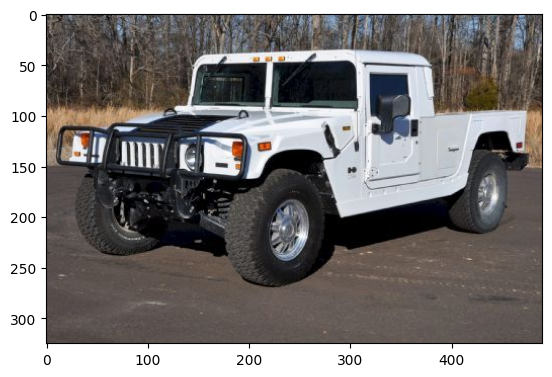

In [2]:
# Path to directory containing data
DataDir = "./Dataset"

# Path to training directory
train_dir = os.path.join(DataDir, 'training/')

# Path to validation directory
val_dir = os.path.join(DataDir, 'validation/')

# Path for damaged training images
train_damage = os.path.join(train_dir, '00-damage')
# Path for training images not damaged
train_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged training images
num_train_damage = len(os.listdir(train_damage))

# Number of training images not damaged
num_train_not_damage = len(os.listdir(train_not_damage))

# Path for damaged validation
val_damage = os.path.join(val_dir, '00-damage')

# Path for validation images not damaged
val_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged validation images
num_val_damage = len(os.listdir(val_damage))

# Number of validation images not damaged
num_val_not_damage = len(os.listdir((val_not_damage)))

# Number of training images
num_train = num_train_damage + num_train_not_damage

# Number of validation images
num_val = num_val_damage + num_val_not_damage


# Total images
total_images = num_val + num_train
print("Total training images",num_train)
print("Total training images (Damaged)", num_train_damage)
print("Total training images (Damaged)", num_train_not_damage)
print()

print("Total validation images", num_val)
print("Total training images (Damaged)", num_val_damage)
print("Total training images (Damaged)", num_val_not_damage)
print()

print("Total Number of Images: ",total_images)


# Plotting a sample image
plt.grid('')
image = plt.imread('./Dataset/training/01-whole/0003.jpg')
plt.imshow(image)
plt.show()


In [3]:
# initializing the hyperparameters
initial_lr = 0.001
epochs = 100
batch_size = 64

# Classes which are detected
classes = ["00-damage", "01-whole"]

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError  # Import error type for handling

# Paths and labels
print("[INFO] loading images...")

data = []  # Stores the data or feature set
labels = []  # Stores the corresponding labels

for class_ in classes:
    path = os.path.join(train_dir, class_)
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        try:
            image_ = load_img(image_path, target_size=(224, 224))
            image_ = img_to_array(image_)
            image_ = preprocess_input(image_)
            
            data.append(image_)
            labels.append(class_)
        except UnidentifiedImageError:
            print(f"[WARNING] Skipping file {image_path}, as it is not a valid image.")

# Repeat for validation set
for class_ in classes:
    path = os.path.join(val_dir, class_)
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        try:
            image_ = load_img(image_path, target_size=(224, 224))
            image_ = img_to_array(image_)
            image_ = preprocess_input(image_)

            data.append(image_)
            labels.append(class_)
        except UnidentifiedImageError:
            print(f"[WARNING] Skipping file {image_path}, as it is not a valid image.")

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split data into training and test sets
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


[INFO] loading images...
[WARNING] Skipping file ./Dataset\training/00-damage\COCO_mul_train_annos.json, as it is not a valid image.
[WARNING] Skipping file ./Dataset\training/00-damage\COCO_train_annos.json, as it is not a valid image.
[WARNING] Skipping file ./Dataset\training/01-whole\.directory, as it is not a valid image.


In [5]:
# loading the MobileNetV2 network, ensuring the topmost fully-connected
# layer sets are left off
model_base = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Constructing the top architecture of our model, which is placed over the 
# pretrained model
model_head = model_base.output
# MaxPooling layer

model_head = MaxPooling2D(pool_size=(5, 5))(model_head)
# Flatten layer
model_head = Flatten(name="flatten")(model_head)

# Activation function relu
model_head = Dense(128, activation="relu")(model_head)

# Performing dropout
model_head = Dropout(0.5)(model_head)

# Final output layer consists of softmax layer
model_head = Dense(2, activation="softmax")(model_head)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_final = Model(inputs=model_base.input, outputs=model_head)


C:\Users\walte\AppData\Local\Temp\ipykernel_13840\3687241744.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_base = MobileNetV2(weights="imagenet", include_top=False,


In [6]:
for layer in model_base.layers:
	layer.trainable = False

In [7]:
from tensorflow.keras.optimizers import Adam

# Setting optimizer with corrected argument
optim = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)

# Compiling the model
model_final.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])


c:\Users\walte\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [8]:
# train the head of the network
model_train = model_final.fit(
#     Generates image generator from ImageGeneratorClass for inputing images in batches
	aug.flow(trainX, trainY, batch_size=batch_size),
#     Number of steps to be taken in one epoch over image batches
	steps_per_epoch=len(trainX) // batch_size,
#     Validation data
	validation_data=(testX, testY),
    
#     Steps for validation data
	validation_steps=len(testX) // batch_size,
    
#     Number of epochs
	epochs=epochs)

c:\Users\walte\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


c:\Users\walte\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 787ms/step - accuracy: 0.6808 - loss: 1.5362 - val_accuracy: 0.8032 - val_loss: 0.4173
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.4435 
Epoch 3/100


c:\Users\walte\AppData\Local\Programs\Python\Python39\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 697ms/step - accuracy: 0.8242 - loss: 0.4037 - val_accuracy: 0.8592 - val_loss: 0.3288
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.8281 - loss: 0.3575 
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 653ms/step - accuracy: 0.8515 - loss: 0.3616 - val_accuracy: 0.8976 - val_loss: 0.2731
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.8906 - loss: 0.3063 
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 673ms/step - accuracy: 0.8579 - loss: 0.3415 - val_accuracy: 0.8656 - val_loss: 0.3118
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.7656 - loss: 0.6216 
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 719ms/step - accuracy: 0.8369 - loss: 0.3778 - val_accuracy: 0.8992 - val_loss: 0.2705
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9062 - loss: 0.2691 
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 642ms/step - accuracy: 0.8630 - loss: 0.3204 - val_accuracy: 0.8848 - val_loss: 0.2890
Epoch 12

In [11]:
# Now, we predict on test set.
predict = model_final.predict(testX, batch_size=batch_size)

# for each image in the test set we find the index of the
# label with corresponding largest predicted probability
predict_index = np.argmax(predict, axis=1)

# Displaying classification report
print(classification_report(testY.argmax(axis=1), predict_index,
	target_names=lb.classes_))

# Storing our model for further use.
model_final.save("Car_detection.model.h5")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step


              precision    recall  f1-score   support

   00-damage       0.94      0.82      0.88       318
    01-whole       0.84      0.95      0.89       307

    accuracy                           0.88       625
   macro avg       0.89      0.89      0.88       625
weighted avg       0.89      0.88      0.88       625



In [27]:
print(model_train.history.keys())
print(f"Number of epochs: {num_epochs}")


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Number of epochs: 100


In [29]:
%matplotlib inline
import os
print(os.getcwd())

c:\Users\walte\Downloads\0Github\DroneInovation\MachineLearning\V1BasicCarDamageDetection


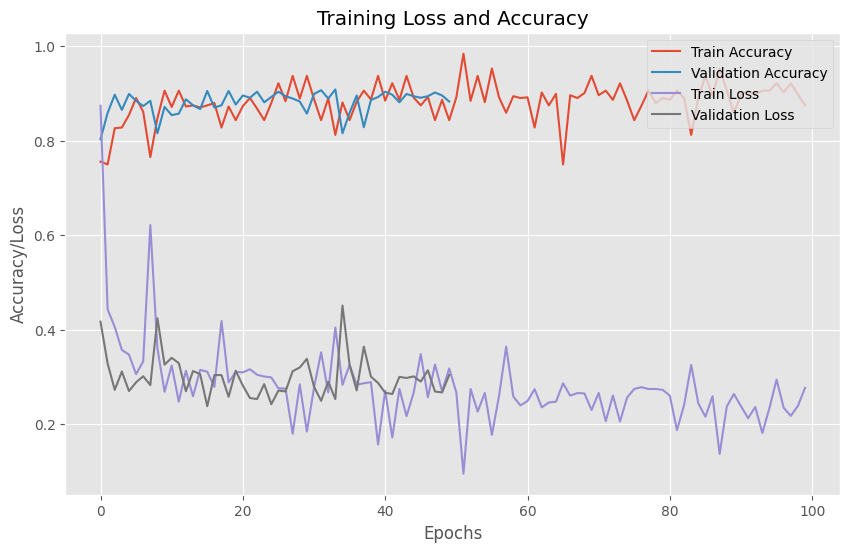

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Use a basic style that should be available
plt.style.use("ggplot")

# Define the number of epochs dynamically
num_epochs = len(model_train.history["accuracy"])

# Define the number of epochs for validation accuracy dynamically, based on the length of "val_accuracy"
num_val_epochs = len(model_train.history["val_accuracy"])

# Start plotting
plt.figure(figsize=(10, 6))

# Plot Train Accuracy
plt.plot(np.arange(0, num_epochs), model_train.history["accuracy"], label="Train Accuracy")

# Plot Validation Accuracy (ensure that both axes are the same length)
plt.plot(np.arange(0, num_val_epochs), model_train.history["val_accuracy"], label="Validation Accuracy")

# Plot Train Loss
plt.plot(np.arange(0, num_epochs), model_train.history["loss"], label="Train Loss")

# Plot Validation Loss
plt.plot(np.arange(0, num_val_epochs), model_train.history["val_loss"], label="Validation Loss")

# Set the title and labels
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="upper right")

# Save the plot as an image
plt.savefig("Car_Detection.png")
plt.show()


In [32]:
# Make predictions on test data (e.g., a single image or batch)
predictions = model_final.predict(testX)

# If you want to print predictions for a sample image
sample_idx = 0  # Adjust the index to test on different images
print(f"Prediction for sample {sample_idx}: {predictions[sample_idx]}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step
Prediction for sample 0: [0.96059716 0.03940285]


In [33]:
# Convert predictions to class labels (e.g., 0 for non-damaged, 1 for damaged)
threshold = 0.5
predicted_class = (predictions[sample_idx] > threshold).astype(int)
print(f"Predicted class for sample {sample_idx}: {predicted_class}")


Predicted class for sample 0: [1 0]


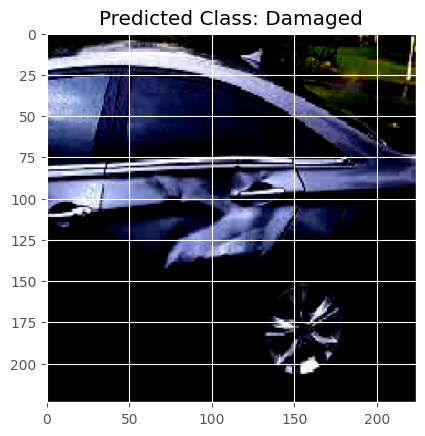

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure to get the predicted class for the sample
sample_idx = 0  # Index of the sample you want to test

# If predictions are probabilities, threshold them to get the class (0 or 1)
predicted_class = (predictions[sample_idx] > 0.5).astype(int)  # Use 0.5 as the threshold for binary classification

# Ensure you're checking the correct value
# If predicted_class is a 2D array (for batch predictions), access the first element
predicted_label = predicted_class[0]  # In case predicted_class is an array

# Plot the image
plt.imshow(testX[sample_idx])

# Use predicted label for the title
plt.title(f"Predicted Class: {'Damaged' if predicted_label == 1 else 'Not Damaged'}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


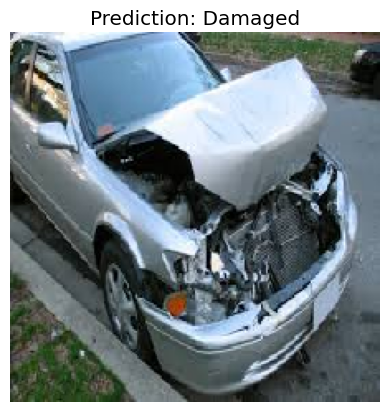

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


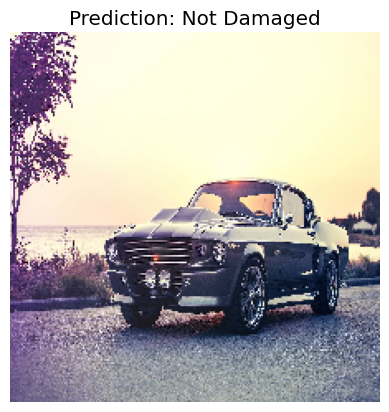

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


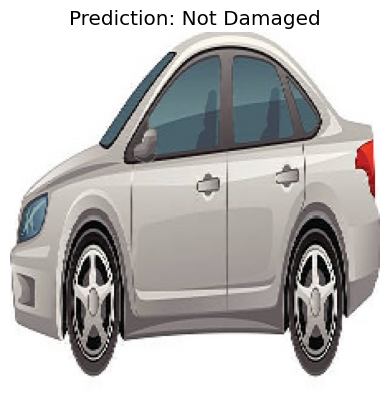

In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define image dimensions based on your model input size
img_height, img_width = 224, 224  # Adjust these dimensions as per your model's input

# List of image paths to test
img_paths = ['./images/d_img1.jpg', './images/g_img1.jpg', './images/Before/Before_test1.jpg']

# Loop through each image
for img_path in img_paths:
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if you applied normalization during training

    # Make prediction
    prediction = model_final.predict(img_array)

    # Convert prediction to class label
    predicted_class = (prediction > 0.5).astype(int)  # This returns an array with a single element

    # Display the image and the result
    plt.imshow(img)
    plt.title(f"Prediction: {'Damaged' if predicted_class[0][0] == 1 else 'Not Damaged'}")
    plt.axis('off')  # Hide axes
    plt.show()
